In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
pd.set_option('use_inf_as_na', True)
from sklearn import tree
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import xgboost as xgb
import numpy as np

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('data/simpl_payments_bank_digicard.csv')

In [3]:
df.describe()

,education_num,capital_gain,capital_loss,hours_per_week,approved,inquiry_purpose_code,account_type,asset_code
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000,43931.000000,45222.000000,45140.000000
mean,10.118460,1101.430344,88.595418,40.938017,0.247844,28.936560,79.807019,1.063735
std,2.552881,7506.430084,404.956092,12.007508,0.431766,35.393095,143.951963,0.711637
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,5.000000,1.000000
25%,9.000000,0.000000,0.000000,40.000000,0.000000,13.000000,5.000000,1.000000
50%,10.000000,0.000000,0.000000,40.000000,0.000000,13.000000,5.000000,1.000000
75%,13.000000,0.000000,0.000000,45.000000,0.000000,16.000000,173.000000,1.000000
max,16.000000,99999.000000,4356.000000,99.000000,1.000000,99.000000,999.000000,19.000000


# What questions are we asking? 

1. Whom to approve or reject for the credit card?
2. How much credit limit to give if approved?

## Some background

ABC Payments Bank is a mobile-only bank based on out Bengaluru, India. Their primary business is to give out digitial credit cards to eligible users with a credit limit ranging from \\$1000 to \\$8000 all over the world. These digital credit cards are issued within an hour after filling up a form in the Bank's mobile app called DigiCard. 

This product provides a very good revenue to the banks, however, it's a challenging task for them to decide who they should approve for the card and who to reject. You have to help this bank decide how they can confidently take this decision baed on the experience they had in the past. 

## Data
The attached CSV has the following columns: 

- user_id
- gender
- data_of_birth
- workclass
- education_level
- education_num: education_level as a continuous variable
- marital_status
- occupation
- relationship: current relationship status
- capital_gain: capital gain made in the last financial year in USD through investments
- capital_loss: capital loss in the last financial year in USD through investments
- hours_per_week: number of hours worked by the person per week
- approved: whether customer was approved for the credit card
- address
- email


More data from a credit bureau. 
- inquiry_purpose_code: purpose of enquiry from the bureau
- institute_type: type of institute that requested the bureau
- account_type: type of account the customer for requesting from the bureau
- asset_class_cd: current state of the assets of the customer
- asset_code: type of ownership fof the customer
- portfolio_type: type of portfolio

# Let's look for missing values

Text(0.5, 1.0, 'Missing Values Heatmap')

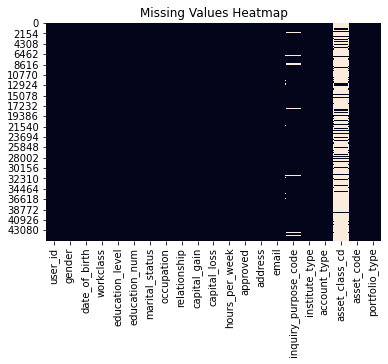

In [4]:
sns.heatmap(df.isnull(), cbar = False)
plt.title('Missing Values Heatmap')

It looks like there are a lot of missing values in `asset_class_cd` and some missing values in `inquire_purpose_code`, but in the data dictionary, it looks like a blank `asset_class_cd` means that it uses the default value, so we can fix that in the data cleaning process. 

# Let's make some plots

Text(0.5, 1.0, 'Gender')

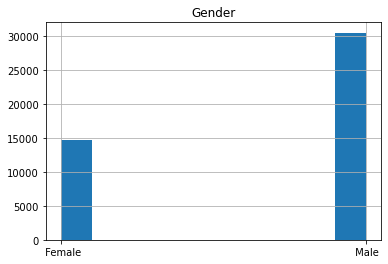

In [5]:
df['gender'].hist()
plt.title('Gender')

Text(0.5, 1.0, 'Work Class')

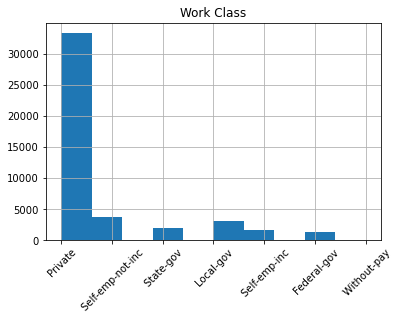

In [6]:
df['workclass'].hist(xrot = 45)
plt.title('Work Class')

Text(0.5, 1.0, 'Education Level')

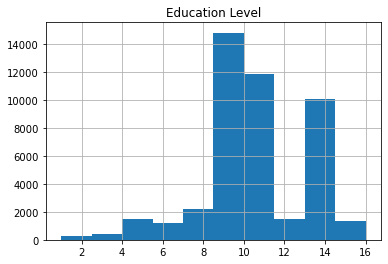

In [7]:
df['education_num'].hist()
plt.title('Education Level')

Text(0.5, 1.0, 'Marital Status')

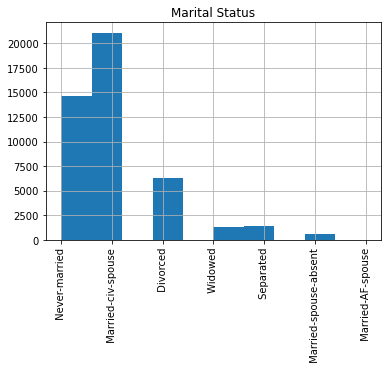

In [8]:
df['marital_status'].hist(xrot = 90)
plt.title('Marital Status')

Text(0.5, 1.0, 'Occupation')

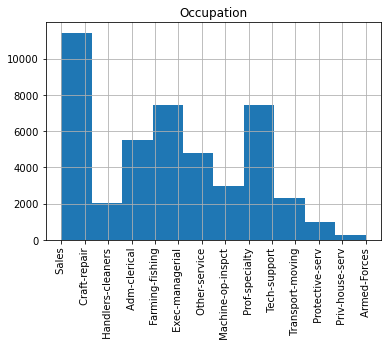

In [9]:
df['occupation'].hist(xrot = 90)
plt.title('Occupation')

Text(0.5, 1.0, 'Capital Gain')

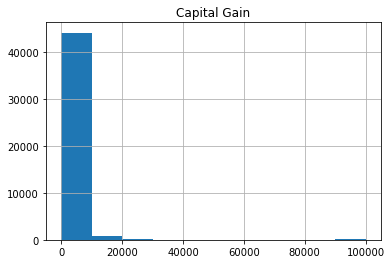

In [10]:
df['capital_gain'].hist()
plt.title('Capital Gain')

Text(0.5, 1.0, 'Capital Loss')

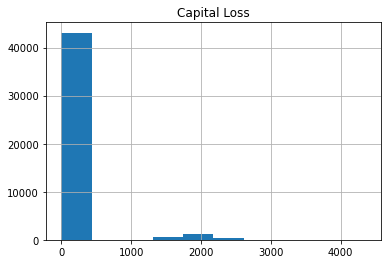

In [11]:
df['capital_loss'].hist()
plt.title('Capital Loss')

Text(0.5, 1.0, 'Hours Per Week')

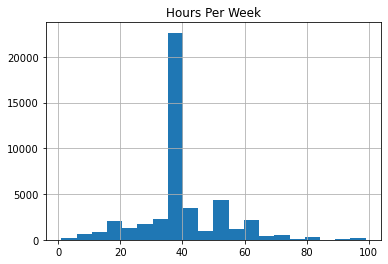

In [12]:
df['hours_per_week'].hist(bins = 20)
plt.title('Hours Per Week')

Text(0.5, 1.0, 'Credit Approved')

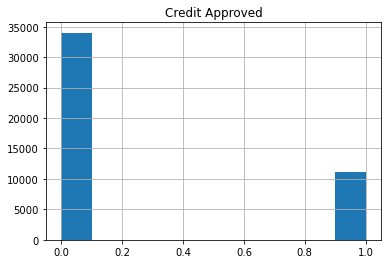

In [13]:
df['approved'].hist()
plt.title('Credit Approved')

Text(0.5, 1.0, 'Inquiry Purpose Code')

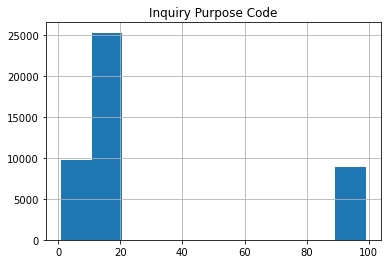

In [14]:
df['inquiry_purpose_code'].hist()
plt.title('Inquiry Purpose Code')

Text(0.5, 1.0, 'Institute Type')

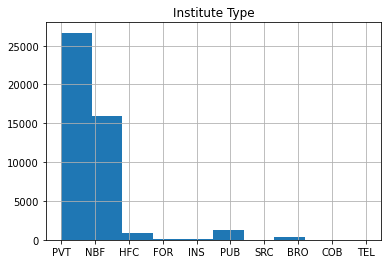

In [15]:
df['institute_type'].hist()
plt.title('Institute Type')

Text(0.5, 1.0, 'Account Type')

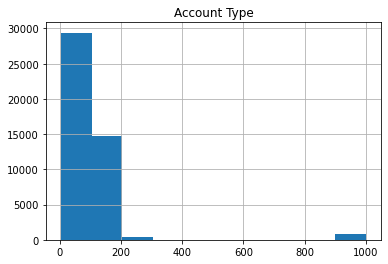

In [16]:
df['account_type'].hist()
plt.title('Account Type')

Text(0.5, 1.0, 'State of Assets')

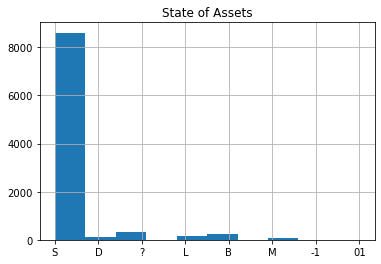

In [17]:
df['asset_class_cd'].hist()
plt.title('State of Assets')

Text(0.5, 1.0, 'Type of Ownership of the Customer')

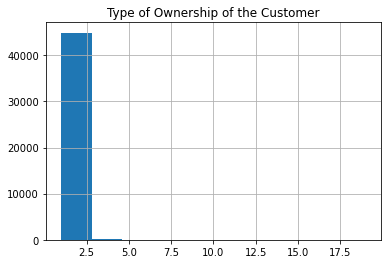

In [18]:
df['asset_code'].hist()
plt.title('Type of Ownership of the Customer')

Text(0.5, 1.0, 'Portfolio Type')

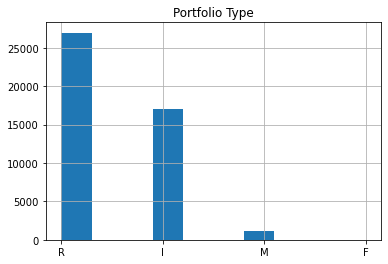

In [19]:
df['portfolio_type'].hist()
plt.title('Portfolio Type')

# Some Discussion before we dive into it

We have two problems. The first is a binary classification problem, with historical data. The second is a bit more challenging. Fundamentally, it's just a regression problem, but it doesn't look like we have the output variable, so we'll need to analyze the model for the classification problem and use that to estimate values for the regression problem. This will be a noisy estimate though and there's no good way to validate this estimate without input from a financial analyst. 

# Let's do some data cleaning

First, we replace the null values from the heatmap above. For the `asset_class_cd`, we assume that the null values are supposed to be -1 and for the `inquiry_purpose_code`, we assumed that the null values were supposed to be 99 (the others class).

In [20]:
df['asset_class_cd'][df['asset_class_cd'].isnull()] = '-1'

In [21]:
df['inquiry_purpose_code'][df['inquiry_purpose_code'].isnull()] = 99.

Text(0.5, 1.0, 'Missing Values Heatmap')

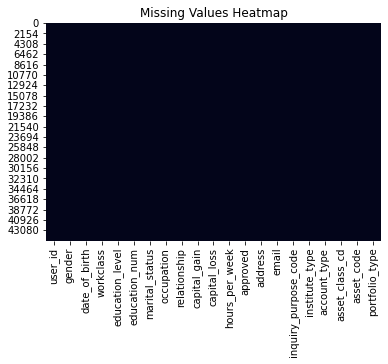

In [22]:
sns.heatmap(df.isnull(), cbar = False)
plt.title('Missing Values Heatmap')

Great! It looks like all of our null values are gone now, let's transform everything so it's easy to train models on this!

In [23]:
le = LabelEncoder()

In [24]:
df['gender'] = le.fit_transform(df['gender'])

In [25]:
df['workclass'] = le.fit_transform(df['workclass'])

In [26]:
df['date_of_birth'] = df['date_of_birth'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').toordinal())

In [27]:
df['marital_status'] = le.fit_transform(df['marital_status'])

In [28]:
df['occupation'] = le.fit_transform(df['occupation'])

In [29]:
df['relationship'] = le.fit_transform(df['relationship'])


In [30]:
df['asset_code'][df['asset_code'].isnull()] = 20.

## Address

Address is an interesting field, the specific address won't predict anything of use, since it'll be unique per user, but zip code and state could be predictive. Let's split address into those values

In [31]:
class Address:
    def __init__(self, address):
        """
        Since our address has a lot of moving elements in it,
        we'll use this to clean some of that up. 
        """
        self.string_address = address
        self.zip = self.get_zip_from_string(address)
        self.state = self.get_state_from_string(address)
        
    def get_zip_from_string(self, address):
        return address[-5:]
    
    def get_state_from_string(self, address):
        return address[-8:-6]
    
   

In [32]:
df['state'] = df['address'].apply(lambda x: Address(x).state)

In [33]:
df['zip'] = df['address'].apply(lambda x: Address(x).zip)

In [34]:
df['zip']

0        83962
1        05193
2        56510
3        51797
4        14128
         ...  
45217    59814
45218    88718
45219    51854
45220    80167
45221    36505
Name: zip, Length: 45222, dtype: object

In [35]:
df['institute_type'] = le.fit_transform(df['institute_type'])

In [36]:
df['state'] = le.fit_transform(df['state'])

In [37]:
df['zip'] = le.fit_transform(df['zip'])

In [38]:
df['portfolio_type'] = le.fit_transform(df['portfolio_type'])

In [39]:
df['user_id'] = le.fit_transform(df['user_id'])

In [40]:
df['asset_class_cd'] = le.fit_transform(df['asset_class_cd'])

# Exploratory Modeling

Ok, now that we're done transforming our data into something that the model can understand. Let's do some explatory modeling. Let's try some quick models. Let's try a k-nearest Neighbors Classifier, a decision tree, a random forest, and an XGBoost Model.

Here's a brief description of each of these: 

1. k-nearest neighbors classifier: k-nearest neighbors assumes that similar things exist in close proximity. KNN captures the idea of similarity. The algorithm effectively looks for the closest k neighbors to the query point, which then "vote" on the classification. 
2. Decision Tree: A decision tree is a flowchart-like structure, where each internal node represents a test that we ask of a given attribute. We have a branch for every outcome of the test, which leads to more tests, finally resulting in the outcome. 
3. Random forest: random forests expand on the idea of decision trees. They create multitudes of decision treest, trained on random selections of the training data. Then, each tree "votes" on the outcome of the classification task. We take advantage of this voting mechanism later on. 
4. XGBoost and Gradient Boosting Classifiers:  An optimized distributed gradient boosting library. Gradient boosting classifiers are a group of machine learnign algorithms that combine many "weak" learning models to create a "stronger" prediction. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models.

We also split our data into training and testing data, where the test set is held out from our model, so we can properly evaluate with our test set. 

In [41]:
features = ['user_id', 'gender', 'date_of_birth', 'workclass',
       'education_num', 'marital_status', 'occupation', 'relationship',
       'capital_gain', 'capital_loss', 'hours_per_week', 'inquiry_purpose_code', 
        'institute_type', 'account_type','asset_class_cd', 'asset_code', 
            'portfolio_type', 'state', 'zip']

In [42]:
X = df[features]
y = df['approved']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [44]:
neigh = KNeighborsClassifier(n_neighbors=50)

In [45]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [46]:
neigh.score(X_test, y_test)

0.7907131011608624

In [47]:
DT = tree.DecisionTreeClassifier()
DT.fit(X_train, y_train)
DT.score(X_test, y_test)

0.8069651741293532

In [48]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=1)
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

0.8645660585959093

In [49]:
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.8630182421227197

In [50]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1)
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

[15:37:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8729684908789387

# Feature Importance
Part of evaluating our model is looking at the most important features. We used permuation importance to find out the most important features. 

As can be seen below, on each model, the most important features are capital gain, relationship, education, date of birth, and other features with varying degrees of importance. In a real-world scenario, I'd also measure the correlation between each feature to make sure that features aren't highly correlated. 

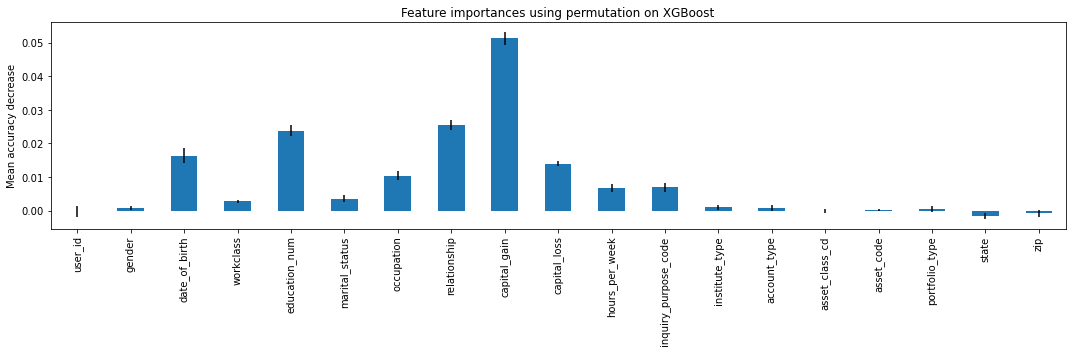

In [51]:
result = permutation_importance(
    xgb_model, X_test, y_test, n_repeats=10, random_state=1, n_jobs=2
)
importances = pd.Series(result.importances_mean, index=features)
fig, ax = plt.subplots(figsize = (15,5))
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on XGBoost")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

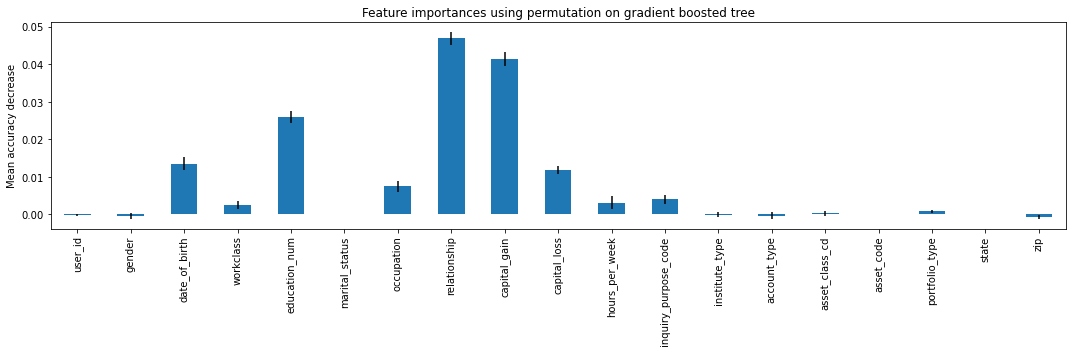

In [52]:
result = permutation_importance(
    gbc, X_test, y_test, n_repeats=10, random_state=1, n_jobs=2
)
importances = pd.Series(result.importances_mean, index=features)
fig, ax = plt.subplots(figsize = (15,5))
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on gradient boosted tree")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

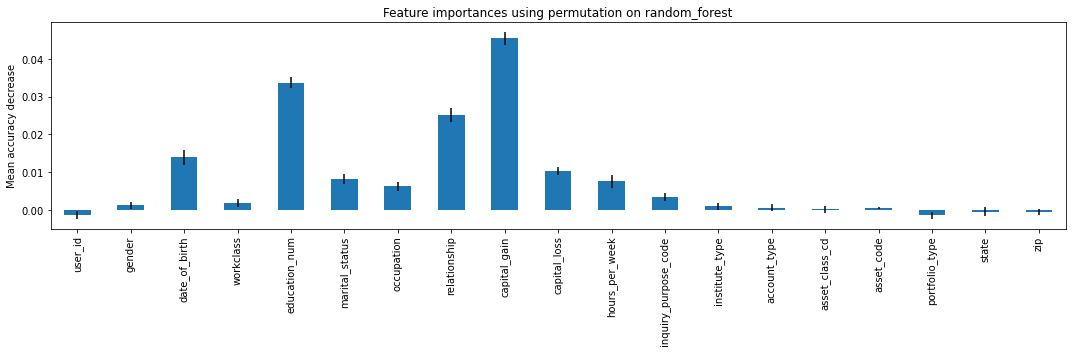

In [53]:
result = permutation_importance(
    random_forest, X_test, y_test, n_repeats=10, random_state=1, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=features)
fig, ax = plt.subplots(figsize = (15,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on random_forest")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Model Validation

We trained a few models that seem to work pretty well for binary classification. Let's do some proper validation. We know the relative accuracies, but let's calculation accuracy, precision, recall, and F1. Let's remember what these terms mean first: 
- accuracy: the number of correctly predicted data points out of all of the data points 
- precision: precision is the number of true positives divided by the number of true positives plus the number of false positives. That is, precision talks about how accurate your model is out of those predicted positive, how many of them are actually positive. This is important in our case, since a false positive is when someone is approved for credit and they shouldn't be. 
- recall: recall is the number of true positives divided by the number of true positives plus the number of false negatives. Recall calculates how many of the actual positives our model captures. 
- F1: F1 is a function of both precision and recall: $$2 * \frac{\rm{Precision} * \rm{Recall}}{\rm{Precision} + \rm{Recall}}$$. F1 score is needed when you want a balance between precision and recall.

In [54]:
def print_classification_stats(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Here are the classification stats for the {} model'.format(model_name))
    accuracy = accuracy_score(y_true = y_test, y_pred = y_pred)
    precision = precision_score(y_true = y_test, y_pred = y_pred)
    recall = recall_score(y_true = y_test, y_pred = y_pred)
    f1 = f1_score(y_true = y_test, y_pred = y_pred)
    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    
    return accuracy, precision, recall, f1

In [55]:
print_classification_stats('XGBoost', xgb_model, X_test, y_test)

Here are the classification stats for the XGBoost model
Accuracy: 0.8729684908789387
Precision: 0.7864028411973617
Recall: 0.6804214223002634
F1: 0.7295834313956225


(0.8729684908789387,
 0.7864028411973617,
 0.6804214223002634,
 0.7295834313956225)

In [56]:
print_classification_stats('Gradient Boosted Tree', gbc, X_test, y_test)

Here are the classification stats for the Gradient Boosted Tree model
Accuracy: 0.8645660585959093
Precision: 0.7814003206841261
Recall: 0.6417910447761194
F1: 0.7047481320800192


(0.8645660585959093,
 0.7814003206841261,
 0.6417910447761194,
 0.7047481320800192)

In [57]:
print_classification_stats('Random Forest', random_forest, X_test, y_test)

Here are the classification stats for the Random Forest model
Accuracy: 0.8630182421227197
Precision: 0.7884508606329816
Recall: 0.6233538191395961
F1: 0.6962490806570237


(0.8630182421227197,
 0.7884508606329816,
 0.6233538191395961,
 0.6962490806570237)

In [58]:
print_classification_stats('k Neighbors', neigh, X_test, y_test)

Here are the classification stats for the k Neighbors model
Accuracy: 0.7907131011608624
Precision: 0.926829268292683
Recall: 0.18349429323968394
F1: 0.30633931843165996


(0.7907131011608624,
 0.926829268292683,
 0.18349429323968394,
 0.30633931843165996)

# Model Evaluation Results

Precision is our most important metric here, as it represents the rate of false positives. That is, we want a low rate of false positives, which is represented by precision. In our case, a false positive represents granting someone a line of credit, when we should not have. A false negative, on the other hand, means rejecting someone that should be qualified for a line of credit. That is, the `risk-averse` models will be higher in precision than recall. The `risk-prone` models will be higher in recall than precision. It will value the marginal benefit of granting an additional line of credit over the potential of that line of credit to default. 

So, our most risk-averse model is the k-nearest neighbors model. However, it has incredibly bad recall, so it'll be a lower profit model in production and it's overall accuracy is the worst of our models. 

The others are all relatively close, but the random forest model has the highest precision, with recall being close to the other two models. Hence, we can continue with the random forest. 

In a real-world scenario, I'd also run a parameter search on each of these models and do much more market and academic background research to explore the space of models. I'd likely also try a neural network and would see what other data points I could gather. I would leverage open data sources as well to get a higher predictive estimate, by combining data that exists in the world with our customer data. If needed, we could also use this model to create a "scorecard" for credit. 

# Estimating Credit to be received

Estimating the amount of credit that each individual is a rather challenging problem with the data given, as we have no feedback for this. Thus, there is no good way to validate. In a real world scenario, I would ask for the feedback of a financial analyst to evaluate random examples from the model. I would also leverage external datasets to see others. That said, this is, by construction, rather arbitrary. Every company accepts a different degree of risk and is willing to loan different amounts of money. In a real world scenario, I'd also do more market research and see if I could use econometrics, machine learning, and financial expertise to create a novel model that better deal with risk to predict credit value. 

## What I used


The random forest model is made of an ensemble of decision trees. We can leverage the voting mechanism to get a probability of getting credit. That is, we have every decision tree in our ensemble predict whether or not the user in question should receive credit. We average these values to get a probability of receiving credit. Then, we use this probability to estimate the amount of credit we should give to each person. The function for doing this, then the histogram of credit estimated is below. I also provide a histogram of predicted approval values vs. real approval values.

In [59]:
def estimate_credit_to_be_received_rf(random_forest, X, df, upper_lim = 8000, lower_lim = 1000):
    """
    This function estimates the amount of credit each person in the dataset df should receive. 
    """
    df['approved_prediction'] = random_forest.predict(X)
    tree_votes = np.array([estimator.predict(X) for estimator in random_forest.estimators_])
    credit_probability = tree_votes.mean(axis = 0) 
    df['credit_probability'] = credit_probability
    df['credit_probability'][df['approved_prediction'] == 1] = \
        df['credit_probability'][df['approved_prediction'] == 1]/.5 - 1
    df['credit_probability'][df['approved_prediction'] == 0] = 0
    df['credit_estimate'] = (df['credit_probability'] * (upper_lim - lower_lim)) + lower_lim
    df['credit_estimate'][df['approved_prediction'] == 0] = 0
    return df

In [60]:
df = estimate_credit_to_be_received_rf(random_forest, X, df)

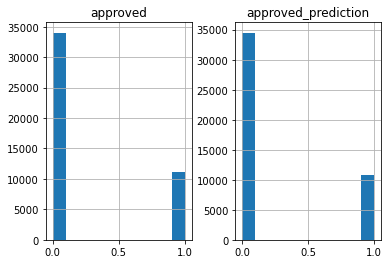

In [61]:
(df[['approved', 'approved_prediction']]).hist()
plt.show()

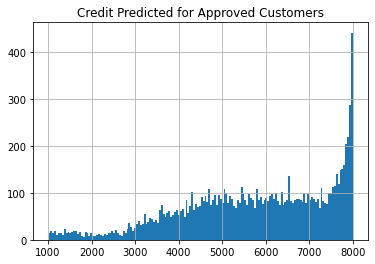

In [62]:
df['credit_estimate'][df['approved_prediction'] == 1].hist(bins = 160)
plt.title('Credit Predicted for Approved Customers')
plt.show()